# NYC Stock Prediction

## Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

price_adj = pd.read_csv("/kaggle/input/nyse/prices-split-adjusted.csv",index_col="date",parse_dates=True)
funda = pd.read_csv("/kaggle/input/nyse/fundamentals.csv")
price = pd.read_csv("/kaggle/input/nyse/prices.csv",index_col="date" ,parse_dates=True)
sec = pd.read_csv("/kaggle/input/nyse/securities.csv")

## EDA

In this section, we explore the dataset, focusing on Apple (AAPL) stock data, and visualize trends, helping us understand the data's characteristics. We also need to find difference between adjusted and non adjusted data.

In [2]:
price.index = pd.to_datetime(price.index, format="mixed")
price_adj.index = pd.to_datetime(price_adj.index, format="mixed")

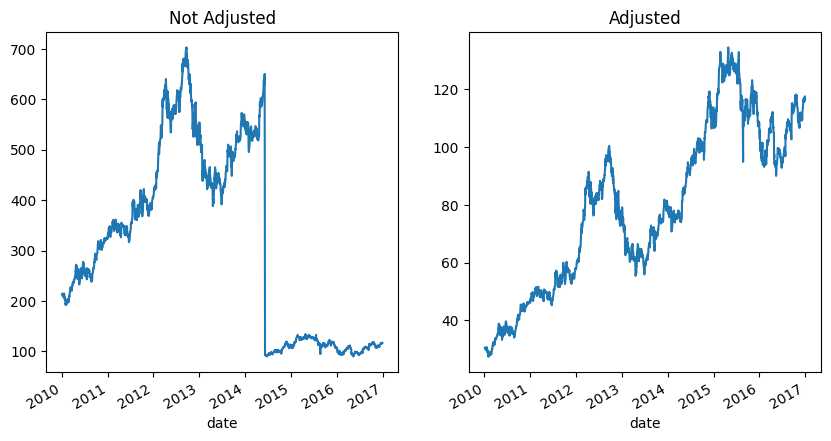

In [3]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
price[price["symbol"]=="AAPL"]["open"].plot(ax=ax[0])
price_adj[price_adj["symbol"]=="AAPL"]["open"].plot(ax=ax[1])
ax[0].set_title("Not Adjusted")
ax[1].set_title("Adjusted")
fig.show()

Due to stock split in 2014, the value of a single apple share dramatically drops. In this project, we will use the adjusted data as it account for splits.

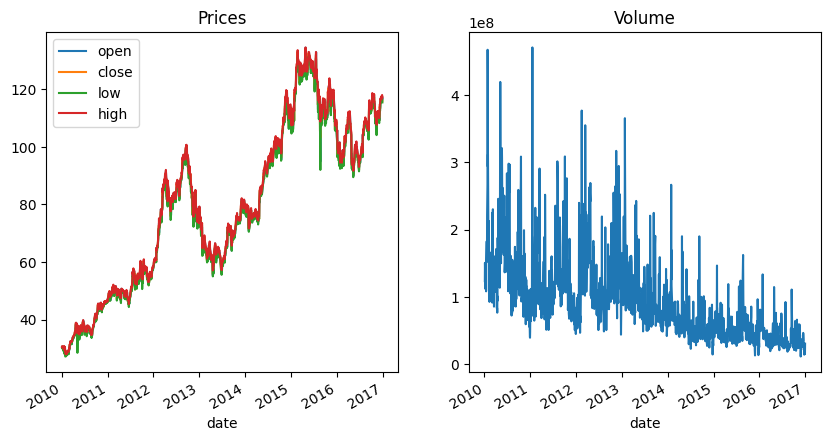

In [4]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
price_adj[price_adj["symbol"]=="AAPL"].drop("volume",axis=1).plot(ax=ax[0])
price_adj[price_adj["symbol"]=="AAPL"]["volume"].plot(ax=ax[1])
ax[0].set_title("Prices")
ax[1].set_title("Volume")
fig.show()


In this project we will first predict open price and then try predict volume

## Preprocessing 

We will wrangle the data to make it suitable for both univariate ("open") and multivariate ("open" and "volume") models.

In [5]:
scaler = MinMaxScaler(feature_range=(-1,1))

data = price_adj[price_adj["symbol"] == "AAPL"]["open"]
scaled_data = scaler.fit_transform(data.values.reshape(-1,1))

data2 = price_adj[price_adj["symbol"] == "AAPL"][["open","volume"]]
scaled_data2 = scaler.fit_transform(data2.values)

In [6]:
def createXY(data,window_size = 5):
    x = []
    y = []
    
    for i in range(len(data)-window_size):
        row = data[i:i+window_size]
        x.append(row)
        label = data[i+window_size][0]
        y.append(label)
    return np.array(x),np.array(y)
def create2XY(data,window_size = 5):
    x = []
    y = []
    
    for i in range(len(data)-window_size):
        row = data[i:i+window_size]
        x.append(row)
        label = data[i+window_size]
        y.append(label)
    return np.array(x),np.array(y)

In [7]:
window_size = 10
x,y = createXY(scaled_data,window_size)
x2,y2 = create2XY(scaled_data2,window_size)

## Modelling (Univariate)

In [34]:
x_train,y_train = x[:1500],y[:1500]
x_val,y_val = x[1500:1600],y[1500:1600]
x_test,y_test = x[1600:],y[1600:]

es = EarlyStopping(monitor="val_loss",patience=5)

In [39]:
def plotForecasts(model,data,x_train,x_val,x_test,y_train,y_val,y_test,window_size):
    fig,ax = plt.subplots(1,1,figsize=(15,5))

    train_pred = model.predict(x_train).flatten()
    train_res = pd.DataFrame(data={"train_pred":train_pred,"actual_train":y_train},index=data[window_size:1500+window_size].index)

    val_pred = model.predict(x_val).flatten()
    val_res = pd.DataFrame(data={"val_pred":val_pred,"actual_val":y_val},index = data[1500+window_size:1600+window_size].index)

    test_pred = model.predict(x_test).flatten()
    test_res = pd.DataFrame(data={"test_pred":test_pred,"actual_test":y_test},index = data[1600+window_size:].index)

    val_res.plot(ax=ax)
    train_res.plot(ax=ax)
    test_res.plot(ax=ax)

    plt.show()

In [14]:
model = Sequential()
model.add(InputLayer((10,1)))
model.add(GRU(64))
model.add(Dense(1,"linear"))
model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.01))
model.fit(x_train,y_train,validation_data = (x_val,y_val),epochs=20,callbacks=[es])

Epoch 1/20
47/47 [==============================] - 4s 32ms/step - loss: 0.0183 - val_loss: 0.0016
Epoch 2/20
47/47 [==============================] - 0s 11ms/step - loss: 9.6122e-04 - val_loss: 0.0014
Epoch 3/20
47/47 [==============================] - 1s 11ms/step - loss: 9.1834e-04 - val_loss: 0.0014
Epoch 4/20
47/47 [==============================] - 1s 11ms/step - loss: 8.8247e-04 - val_loss: 0.0022
Epoch 5/20
47/47 [==============================] - 1s 11ms/step - loss: 9.1479e-04 - val_loss: 0.0013
Epoch 6/20
47/47 [==============================] - 0s 10ms/step - loss: 8.4923e-04 - val_loss: 0.0013
Epoch 7/20
47/47 [==============================] - 1s 11ms/step - loss: 8.6873e-04 - val_loss: 0.0016
Epoch 8/20
47/47 [==============================] - 1s 11ms/step - loss: 8.3883e-04 - val_loss: 0.0014
Epoch 9/20
47/47 [==============================] - 1s 11ms/step - loss: 9.5513e-04 - val_loss: 0.0014
Epoch 10/20
47/47 [==============================] - 0s 10ms/step - loss: 9.0

5/5 [==============================] - 0s 4ms/step


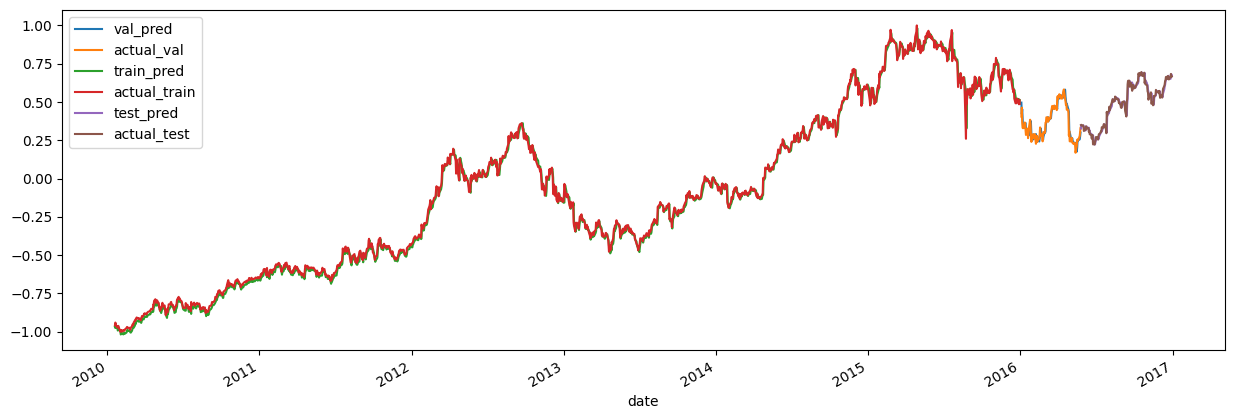

In [15]:
plotForecasts(model,data,x_train,x_val,x_test,y_train,y_val,y_test,window_size)

## Modelling (Multivariate)
We will also try predicting two time series at one

In [16]:
x_train,y_train = x2[:1500],y2[:1500]
x_val,y_val = x2[1500:1600],y2[1500:1600]
x_test,y_test = x2[1600:],y2[1600:]

In [18]:
def plotMForecasts(model,x_train,x_val,x_test,scaled_data2,data):
    fig,ax = plt.subplots(1,2,figsize=(20,5))

    train_res = pd.DataFrame(data = model.predict(x_train), columns = ["open","volume"], index=data[window_size:1500+window_size].index)

    train_res["open"].plot(ax=ax[0])
    train_res["volume"].plot(ax=ax[1])

    val_res = pd.DataFrame(data = model.predict(x_val), columns = ["open","volume"], index=data[1500+window_size:1600+window_size].index)

    val_res["open"].plot(ax=ax[0])
    val_res["volume"].plot(ax=ax[1])

    test_res = pd.DataFrame(data = model.predict(x_test), columns = ["open","volume"], index=data[1600+window_size:].index)

    test_res["open"].plot(ax=ax[0])
    test_res["volume"].plot(ax=ax[1])

    scaled_df2 = pd.DataFrame(data = scaled_data2, columns = ["open","volume"],index=data.index)

    scaled_df2["open"].plot(ax=ax[0])
    scaled_df2["volume"].plot(ax=ax[1])

    fig.show()


In [20]:
model = Sequential()
model.add(InputLayer((10,2)))
model.add(GRU(64))
model.add(Dense(2,"linear"))
model.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.01))
model.fit(x_train,y_train,validation_data = (x_val,y_val),epochs=20,callbacks=[es])

Epoch 1/20
47/47 [==============================] - 4s 22ms/step - loss: 0.0312 - val_loss: 0.0069
Epoch 2/20
47/47 [==============================] - 1s 11ms/step - loss: 0.0143 - val_loss: 0.0031
Epoch 3/20
47/47 [==============================] - 1s 12ms/step - loss: 0.0142 - val_loss: 0.0032
Epoch 4/20
47/47 [==============================] - 1s 11ms/step - loss: 0.0142 - val_loss: 0.0044
Epoch 5/20
47/47 [==============================] - 1s 11ms/step - loss: 0.0140 - val_loss: 0.0055
Epoch 6/20
47/47 [==============================] - 1s 11ms/step - loss: 0.0139 - val_loss: 0.0044
Epoch 7/20
47/47 [==============================] - 1s 11ms/step - loss: 0.0136 - val_loss: 0.0042


5/5 [==============================] - 0s 4ms/step


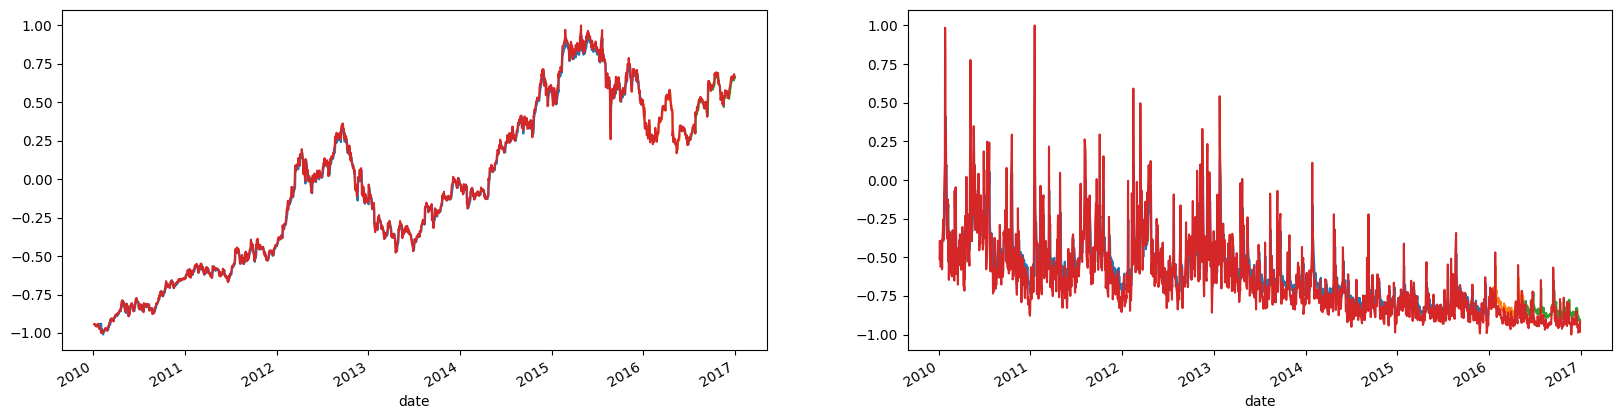

In [21]:
plotMForecasts(model,x_train,x_val,x_test,scaled_data2,data)
